In [1]:
!pip install CoolProp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.6 MB/s eta 0:00:00


In [2]:
from CoolProp.CoolProp import PropsSI
import CoolProp as CP
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/My Drive/Thermo-thesis/')
from sCO2Utils import *
from config import Config

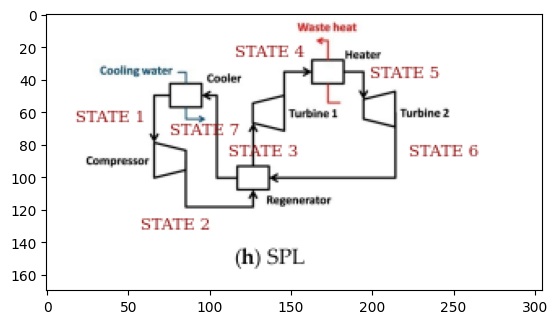

In [5]:
img = plt.imread('SPL_setup.png')
plt.imshow(img)

Let us define the pressure ratios for SPL design

$r_p^1 = \frac{P_2}{P_1}$

$r_p^2 = \frac{P_4}{P_1}$

$P_1< P_4 < P_2$, divide by $P_1$

$1 < \frac{P_4}{P_1} < \frac{P_2}{P_1}$, but $P_3=P_2$, thus

$1< r_p^2 < r_p^1$

In [6]:
def resolve_SPL_cycle(
    P1 : float,
    T1 : float,
    T5 : float,
    pump_isentropic_efficiency : float,
    turbine_isentropic_efficiency : float,
    heat_exchanger_efficiency : float,
    rp1 : float,
    rp2 : float,
    grading : float
):

  P6,P7 = P1,P1
  P2 = P1*rp1
  P3 = P2
  P4 = P1*rp2
  P5 = P4

  ############ Compute known states######################
  state1 = ThermodynamicState(p = P1,t = T1); state1.compute_from_p_t();
  state5 = ThermodynamicState(p = P5,t = T5); state5.compute_from_p_t();

  turbine1 = Turbine(isentropic_efficiency=turbine_isentropic_efficiency,output_pressure=P4)
  turbine2 = Turbine(isentropic_efficiency=turbine_isentropic_efficiency,output_pressure=P1)
  pump = Pump(isentropic_efficiency=pump_isentropic_efficiency,output_pressure=P2)

  state2 = pump.resolve_actual_output_state(input_state = state1)
  state6 = turbine2.resolve_actual_output_state(input_state = state5)
  ###########################################################

  heat_exchanger = HeatExchanger(
      stream1_entry_state=state2,
      stream2_entry_state=state6,
      grading = grading,
      efficiency = heat_exchanger_efficiency
  )

  state3, state7 = heat_exchanger.resolve_exit_states()

  state4 = turbine1.resolve_actual_output_state(input_state = state3)

  qout = state7.h -state1.h
  qin = state5.h - state4.h
  eta = 1 - qout/qin # Compute Efficiency

  return [eta, [state1,state2,state3,state4,state5,state6,state7]]

In [7]:
# INITIAL CONDITIONS
P1 = Config.rankine_Pmin
T1 = Config.T1
T5 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency
heat_exchanger_efficiency = Config.heat_exchanger_efficiency

In [8]:
rp_min = Config.rankine_rp_min
rp_max = Config.rankine_rp_max
N = 25 # points
M = 25 # points
rp1_list = list(np.linspace(rp_min,rp_max,N))
grading = 1

SPL_efficiency = np.zeros((N,M))

for rp1_id, rp1 in enumerate(list(rp1_list)):
  rp2_list = list(np.linspace(1.5,rp1,M))
  for rp2_id, rp2 in enumerate(rp2_list):
    SPL_efficiency[rp1_id, rp2_id] = resolve_SPL_cycle(
        P1 = P1,
        T1 = T1,
        T5 = T5,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp1 = rp1,
        rp2=rp2,
        grading = grading
    )[0]

In [9]:
fig = go.Figure(data=[go.Surface(z=np.clip(SPL_efficiency, a_min =0, a_max =1), y = rp2_list, x = rp1_list)])
fig.update_layout(title='Rankine efficiency vs pressure ratio SPL design')
fig.update_scenes(xaxis_title_text='P2/P1 ratio',
                  yaxis_title_text='P4/P1 ratio',
                  zaxis_title_text='Efficiency ')
fig.show()

In [10]:
# The maximum efficiency is achieved for
max_index = np.where(SPL_efficiency == SPL_efficiency.max())
# Thus we have
rp1_best = rp1_list[max_index[1][0]]
rp2_list = list(np.linspace(1.5,rp1_best,M))
rp2_best = rp2_list[max_index[0][0]]
print(rp1_best, rp2_best)

4.9 3.4833333333333334


In [11]:
print(f'The maximum of efficiency of {"{:.2f}".format(SPL_efficiency.max()*100)} % is reached for rp1 = {rp1_best} and rp2 = {rp2_best}')

The maximum of efficiency of 15.05 % is reached for rp1 = 4.9 and rp2 = 3.4833333333333334


In [12]:
# Pick the best performing pressure ratio
_eta, states_list = resolve_SPL_cycle(
  P1 = P1,
  T1 = T1,
  T5 = T5,
  pump_isentropic_efficiency=pump_isentropic_efficiency,
  turbine_isentropic_efficiency=turbine_isentropic_efficiency,
  heat_exchanger_efficiency= heat_exchanger_efficiency,
  rp1 = rp1_best,
  rp2=rp2_best,
  grading = 1
  )

In [13]:
show_states_table(states_list)

   pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1   7.190000e+06       303.000000        302.929951          1.338232
2   3.523100e+07       356.433918        351.381708          1.365612
3   3.523100e+07       359.488924        357.283868          1.382101
4   2.504517e+07       347.020430        345.676320          1.388011
5   2.504517e+07       473.000000        582.520368          1.977725
6   7.190000e+06       365.258567        515.789741          2.010362
7   7.190000e+06       360.804408        509.887581          1.994104


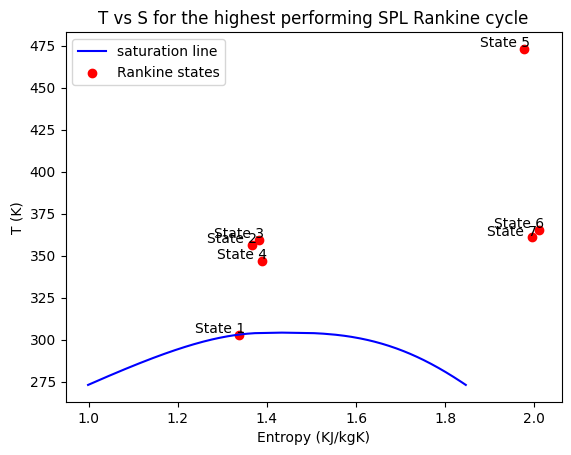

In [14]:
fig, ax = plot_tvss_phase_transition_region(273, 'T vs S for the highest performing SPL Rankine cycle')
state_xpoints = [state.s for state in states_list]
state_ypoints = [state.t for state in states_list]
ax.text(state_xpoints[0] - .1, state_ypoints[0] + 1,'State 1')
ax.text(state_xpoints[1] - .1, state_ypoints[1] + 1,'State 2')
ax.text(state_xpoints[2] - .1, state_ypoints[2] + 1,'State 3')
ax.text(state_xpoints[3] - .1, state_ypoints[3] + 1,'State 4')
ax.text(state_xpoints[4] - .1, state_ypoints[4] + 1,'State 5')
ax.text(state_xpoints[5] - .1, state_ypoints[5] + 1,'State 6')
ax.text(state_xpoints[6] - .1, state_ypoints[6] + 1,'State 7')
ax.scatter(state_xpoints, state_ypoints, color = 'red', label = 'Rankine states')
ax.legend()

# NOW FOR BRAYTON

In [15]:
# INITIAL CONDITIONS
P1 = Config.brayton_Pmin
T1 = Config.T1
T5 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency
heat_exchanger_efficiency = Config.heat_exchanger_efficiency

In [16]:
rp_min = Config.brayton_rp_min
rp_max = Config.brayton_rp_max
N = 10 # points
M = 10 # points
rp1_list = list(np.linspace(rp_min,rp_max,N))
grading = 1

SPL_efficiency = np.zeros((N,M))


for rp1_id, rp1 in enumerate(list(rp1_list)):
  rp2_list = list(np.linspace(1.5,rp1,M))
  for rp2_id, rp2 in enumerate(rp2_list):
    SPL_efficiency[rp1_id, rp2_id] = resolve_SPL_cycle(
        P1 = P1,
        T1 = T1,
        T5 = T5,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp1 = rp1,
        rp2=rp2,
        grading = grading
    )[0]

In [17]:
fig = go.Figure(data=[go.Surface(z=np.clip(SPL_efficiency, a_min =0, a_max =1), y = rp2_list, x = rp1_list)])
fig.update_layout(title='Brayton efficiency vs pressure ratio SPL design')
fig.update_scenes(xaxis_title_text='P2/P1 ratio',
                  yaxis_title_text='P4/P1 ratio',
                  zaxis_title_text='Efficiency ')
fig.show()

In [18]:
# The maximum efficiency is achieved for
max_index = np.where(SPL_efficiency == SPL_efficiency.max())
# Thus we have
rp1_best = rp1_list[max_index[1][0]]
rp2_list = list(np.linspace(1.5,rp1_best,M))
rp2_best = rp2_list[max_index[0][0]]
print(rp1_best, rp2_best)

4.67 3.261111111111111


In [19]:
print(f'The Brayton maximum of efficiency of {"{:.2f}".format(SPL_efficiency.max()*100)} % is reached for rp1 = {rp1_best} and rp2 = {rp2_best}')

The Brayton maximum of efficiency of 14.74 % is reached for rp1 = 4.67 and rp2 = 3.261111111111111


In [20]:
# Pick the best performing pressure ratio
_eta, brayton_states_list = resolve_SPL_cycle(
  P1 = P1,
  T1 = T1,
  T5 = T5,
  pump_isentropic_efficiency=pump_isentropic_efficiency,
  turbine_isentropic_efficiency=turbine_isentropic_efficiency,
  heat_exchanger_efficiency= heat_exchanger_efficiency,
  rp1 = rp1_best,
  rp2=rp2_best,
  grading = 1
  )

In [21]:
show_states_table(brayton_states_list)

   pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1   7.500000e+06       303.000000        290.458448          1.295477
2   3.502500e+07       348.181132        335.613597          1.321591
3   3.502500e+07       355.973900        350.676092          1.364374
4   2.445833e+07       343.451145        338.812050          1.370478
5   2.445833e+07       473.000000        584.158509          1.985026
6   7.500000e+06       370.471176        520.182610          2.015856
7   7.500000e+06       359.261853        505.120115          1.974565


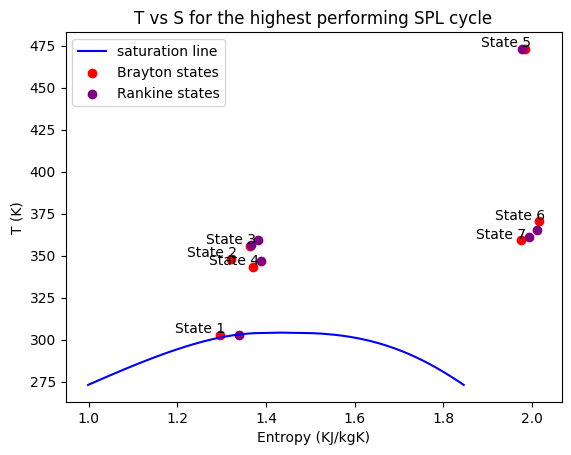

In [22]:
fig, ax = plot_tvss_phase_transition_region(273, 'T vs S for the highest performing SPL cycle')
brayton_state_xpoints = [state.s for state in brayton_states_list]
brayton_state_ypoints = [state.t for state in brayton_states_list]
ax.text(brayton_state_xpoints[0] - .1, brayton_state_ypoints[0] + 1,'State 1')
ax.text(brayton_state_xpoints[1] - .1, brayton_state_ypoints[1] + 1,'State 2')
ax.text(brayton_state_xpoints[2] - .1, brayton_state_ypoints[2] + 1,'State 3')
ax.text(brayton_state_xpoints[3] - .1, brayton_state_ypoints[3] + 1,'State 4')
ax.text(brayton_state_xpoints[4] - .1, brayton_state_ypoints[4] + 1,'State 5')
ax.text(brayton_state_xpoints[5] - .1, brayton_state_ypoints[5] + 1,'State 6')
ax.text(brayton_state_xpoints[6] - .1, brayton_state_ypoints[6] + 1,'State 7')
ax.scatter(brayton_state_xpoints, brayton_state_ypoints, color = 'red', label = 'Brayton states')
ax.scatter(state_xpoints, state_ypoints, color = 'purple', label = 'Rankine states')
ax.legend()

In [23]:
show_states_table(states_list)

   pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1   7.190000e+06       303.000000        302.929951          1.338232
2   3.523100e+07       356.433918        351.381708          1.365612
3   3.523100e+07       359.488924        357.283868          1.382101
4   2.504517e+07       347.020430        345.676320          1.388011
5   2.504517e+07       473.000000        582.520368          1.977725
6   7.190000e+06       365.258567        515.789741          2.010362
7   7.190000e+06       360.804408        509.887581          1.994104
